Building a time series model for forecasting.
Since levels usually exhibit both a long-term upward trend and seasonal fluctuations, an LSTM (Long Short-Term Memory) network is a great choice because it can "remember" those long-term patterns.
Below is a complete implementation using TensorFlow/Keras.

1. Setup


In [9]:
# Setup and Loading Libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
from google.colab import files



- Create Data directory and load the raw csv data into Data directory.

In [2]:
#Creating Data directory
!mkdir data

In [3]:
#Loading data
# Configuration
data_dir = './data'
file_name = 'IoT_Indoor_Air_Quality_Dataset.csv'
file_path = os.path.join(data_dir, file_name)

# 1. Ensure the directory exists
os.makedirs(data_dir, exist_ok=True)

# Load the dataset
df = pd.read_csv('./data/IoT_Indoor_Air_Quality_Dataset.csv')

# Display basic info and the first few rows
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97458 entries, 0 to 97457
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Timestamp              97458 non-null  object 
 1   Temperature (?C)       95509 non-null  float64
 2   Humidity (%)           95509 non-null  float64
 3   CO2 (ppm)              95509 non-null  float64
 4   PM2.5 (?g/m?)          95509 non-null  float64
 5   PM10 (?g/m?)           95509 non-null  float64
 6   TVOC (ppb)             95509 non-null  float64
 7   CO (ppm)               95509 non-null  float64
 8   Light Intensity (lux)  95509 non-null  float64
 9   Motion Detected        95509 non-null  float64
 10  Occupancy Count        95509 non-null  float64
 11  Ventilation Status     95509 non-null  object 
dtypes: float64(10), object(2)
memory usage: 8.9+ MB
None
          Timestamp  Temperature (?C)  Humidity (%)  CO2 (ppm)  PM2.5 (?g/m?)  \
0  18-02-2024 08:00     

- Convert Timestamps into datetime format.

Data ranges from 2024-02-18 08:00:00 to 2025-01-22 17:25:00
count    97458.000000
mean       700.342582
std        172.604190
min        400.000000
25%        551.230000
50%        700.540000
75%        849.205000
max        999.990000
Name: CO2 (ppm), dtype: float64


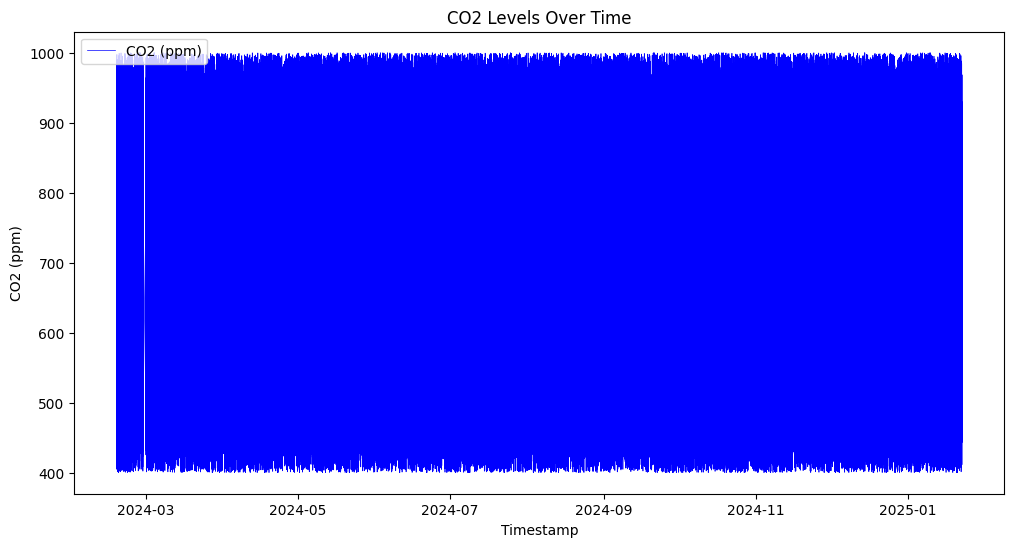

In [4]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M')

# Sort by timestamp
df = df.sort_values('Timestamp').reset_index(drop=True)

# Interpolate missing values for CO2
df['CO2 (ppm)'] = df['CO2 (ppm)'].interpolate(method='linear')

# Drop remaining NaNs in CO2 if any
df = df.dropna(subset=['CO2 (ppm)'])

# Check time range
start_time = df['Timestamp'].min()
end_time = df['Timestamp'].max()
print(f"Data ranges from {start_time} to {end_time}")

# Plot CO2 over time
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['CO2 (ppm)'], label='CO2 (ppm)', color='blue', linewidth=0.5)
plt.title('CO2 Levels Over Time')
plt.xlabel('Timestamp')
plt.ylabel('CO2 (ppm)')
plt.legend()
plt.savefig('co2_time_series.png')

# Summary statistics for CO2
print(df['CO2 (ppm)'].describe())

1. Load and Pre-process Data

In [62]:
# 1. Load and Preprocess Data
df = pd.read_csv('./data/IoT_Indoor_Air_Quality_Dataset.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)
df = df.sort_values('Timestamp').dropna(subset=['CO2 (ppm)'])

# Using a subset for faster training (last 10000 rows is plenty for a demo)
data = df[['CO2 (ppm)']].values[-10000:]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

2. Data Normalisation & Create Sequence Generation (Sliding Window)

In [63]:
# Use the preprocessed 'CO2 (ppm)' column from the existing dataframe 'df'
data = df['CO2 (ppm)'].values.reshape(-1, 1)

# 1. Normalize the data to a range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


# 2. Create Sequences (Sliding Window)
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(x), np.array(y)

# Window of 60 steps (5 hours of history)
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Reshape for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split: Last 288 steps (24 hours) for testing
test_size = 288
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]



3. Build LSTM Model
- We define a simple RNN structure. The input shape must be (samples, time_steps, features).




In [65]:
# 3. Build LSTM Model
model = Sequential([
     LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
     Dropout(0.2),
     LSTM(32),
     Dropout(0.2),
     Dense(1)   # Predicting a single value
])

model.compile(optimizer='adam', loss='mean_squared_error')

4. Train the model

In [86]:
# 4. Train Model
# Using 5x epochs for speed in environment
print("Training model...")
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)



Training model...
Epoch 1/5
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0838 - val_loss: 0.0839
Epoch 2/5
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0835 - val_loss: 0.0839
Epoch 3/5
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0841 - val_loss: 0.0839
Epoch 4/5
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0835 - val_loss: 0.0839
Epoch 5/5
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0837 - val_loss: 0.0839


5 Forecast and Evaluate (Part 1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Evaluation Metrics:
MAE: 141.55
RMSE: 165.62
R2 Score: -0.00


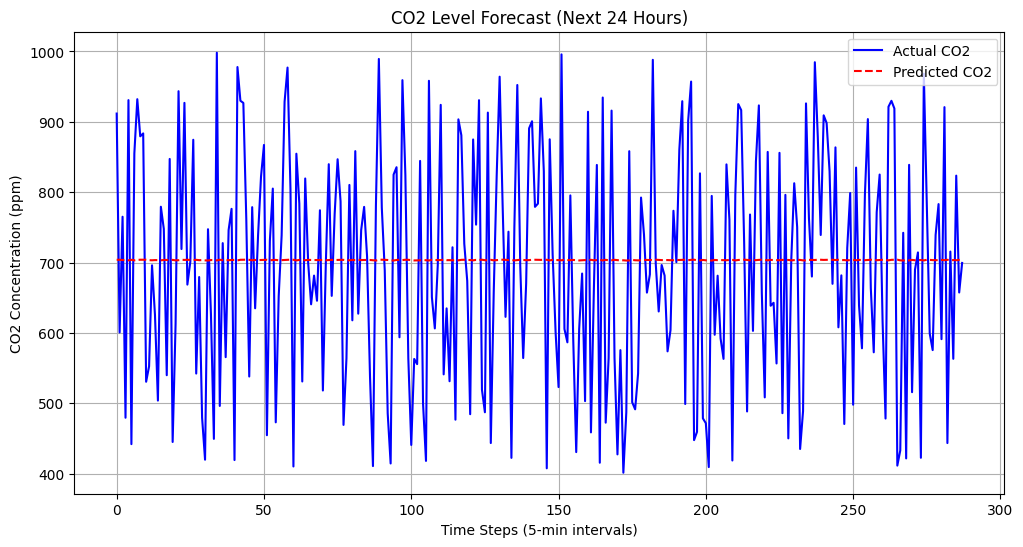

In [70]:
# 5. Forecast and Evaluation
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print(f"Evaluation Metrics:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2 Score: {r2:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual CO2', color='blue')
plt.plot(predictions, label='Predicted CO2', color='red', linestyle='dashed')
plt.title('CO2 Level Forecast (Next 24 Hours)')
plt.xlabel('Time Steps (5-min intervals)')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid(True)
plt.savefig('co2_forecast_plot.png')

# Save predictions for user
forecast_df = pd.DataFrame({'Actual': actuals.flatten(), 'Predicted': predictions.flatten()})
forecast_df.to_csv('co2_forecast_results.csv', index=True)


In [71]:
# 4. Train Model
# Using 10x epochs for speed in environment
print("Training model...")
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)



Training model...
Epoch 1/10
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 56s 42ms/step - loss: 0.0837 - val_loss: 0.0838
Epoch 2/10
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 51s 38ms/step - loss: 0.0833 - val_loss: 0.0838
Epoch 3/10
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - loss: 0.0835 - val_loss: 0.0839
Epoch 4/10
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - loss: 0.0834 - val_loss: 0.0839
Epoch 5/10
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - loss: 0.0833 - val_loss: 0.0838
Epoch 6/10
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - loss: 0.0836 - val_loss: 0.0838
Epoch 7/10
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 51s 38ms/step - loss: 0.0838 - val_loss: 0.0838
Epoch 8/10
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 51s 38ms/step - loss: 0.0833 - val_loss: 0.0839
Epoch 9/10
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 51s 38ms/step - loss: 0.0838 - val_loss: 0.0839
Epoch 10/10
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - loss: 0.0831 - val_loss: 0.0839


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Evaluation Metrics:
MAE: 141.49
RMSE: 165.52
R2 Score: -0.00


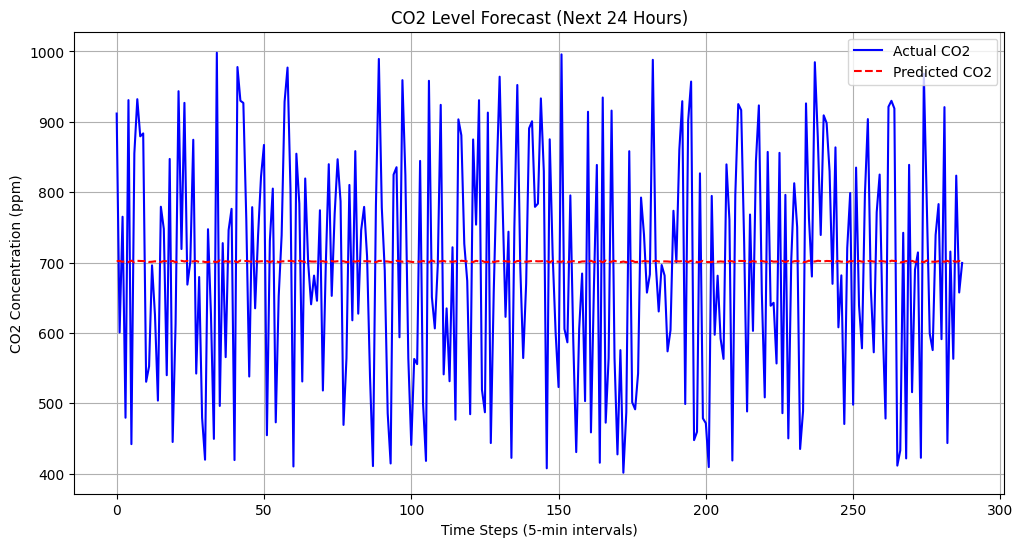

In [73]:
# 5. Forecast and Evaluation
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print(f"Evaluation Metrics:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2 Score: {r2:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual CO2', color='blue')
plt.plot(predictions, label='Predicted CO2', color='red', linestyle='dashed')
plt.title('CO2 Level Forecast (Next 24 Hours)')
plt.xlabel('Time Steps (5-min intervals)')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid(True)
plt.savefig('co2_forecast_plot.png')

# Save predictions for user
forecast_df = pd.DataFrame({'Actual': actuals.flatten(), 'Predicted': predictions.flatten()})
forecast_df.to_csv('co2_forecast_results.csv', index=True)


** Alternative Building with WINDOW SIZE (Sequence Generation - Windowing)

In [84]:
# 2. Create sequences (Windowing)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 12  # Use 12 months to predict the 13th month
X, y = create_sequences(scaled_data, WINDOW_SIZE)

# Split into train and test sets (80/20)
#split = int(len(X) * 0.8)
#X_train, X_test = X[:split], X[split:]
#y_train, y_test = y[:split], y[split:]


# Split: Last 288 steps (24 hours) for testing
test_size = 288
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]



# 3. Build the Model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(WINDOW_SIZE, 1), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1) # Predicting a single value
])

model.compile(optimizer='adam', loss='mse')

# 4. Train
print("Training model...")
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


Training model...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5951/5951 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.0872 - val_loss: 0.0762
Epoch 2/10
5951/5951 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.0835 - val_loss: 0.0761
Epoch 3/10
5951/5951 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.0837 - val_loss: 0.0759
Epoch 4/10
5951/5951 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0839 - val_loss: 0.0762
Epoch 5/10
5951/5951 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0839 - val_loss: 0.0760
Epoch 6/10
5951/5951 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0836 - val_loss: 0.0769
Epoch 7/10
5951/5951 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0838 - val_loss: 0.0765
Epoch 8/10
5951/5951 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0837 - val_loss: 0.0759
Epoch 9/10
5951/5951 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 0.0838 - val_loss: 0.0760
Epoch 10/10
5951/5951 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.0834 - val_loss: 0.0769


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Evaluation Metrics:
MAE: 141.92
RMSE: 166.40
R2 Score: -0.01


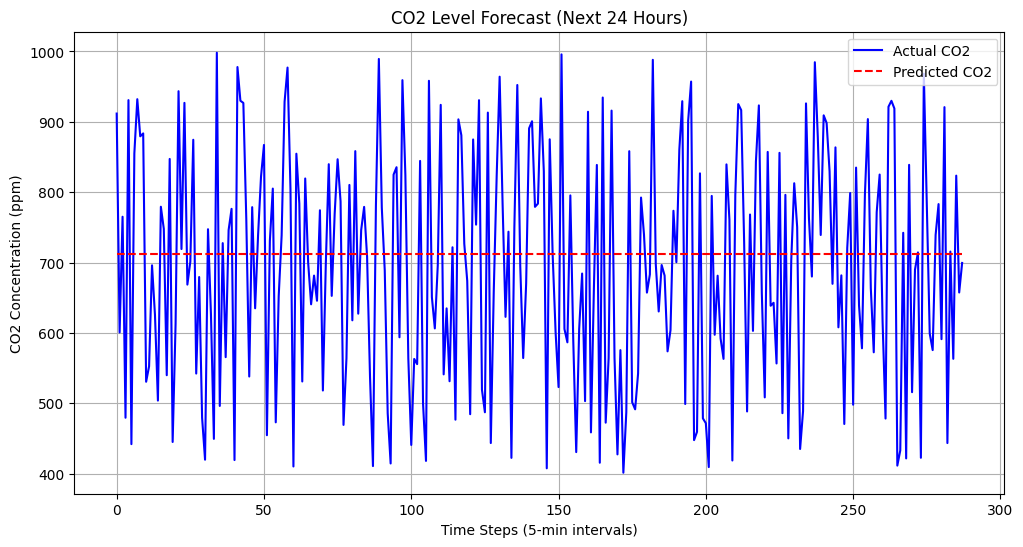

In [85]:
# 5. Forecast and Evaluation
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print(f"Evaluation Metrics:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2 Score: {r2:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual CO2', color='blue')
plt.plot(predictions, label='Predicted CO2', color='red', linestyle='dashed')
plt.title('CO2 Level Forecast (Next 24 Hours)')
plt.xlabel('Time Steps (5-min intervals)')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid(True)
plt.savefig('co2_forecast_plot.png')

# Save predictions for user
forecast_df = pd.DataFrame({'Actual': actuals.flatten(), 'Predicted': predictions.flatten()})
forecast_df.to_csv('co2_forecast_results.csv', index=True)
